In [10]:
from easydict import EasyDict as edict

args = edict({
    'data_dir': 'data/',
    'word_dir': 'data_mapping/',
    'window_sz': 3,
    'mfcc_dim': 13,
    'embedding_dim': 50,
    'lr': 1e-3,
    'batch_sz': 32,
    'epochs': 10,
    'device': 'cpu',
    'print_itr': 10,
    'ckpt_dir': 'ckpt',
    'ckpt_n': '9.pt',
})

In [11]:
import os

from model import *
from dataset import *
# from tqdm.notebook import tqdm

In [16]:
def save_ckpt(ckpt_dir, ckpt_n, keep_topk=5, **kwargs):
    fs = sorted([f for f in os.listdir(ckpt_dir) if f[-3: ] == '.pt'], 
                key=lambda f: int(f.split('.')[0]))
    
    if keep_topk <= len(fs):     # trick to delete ckpt
        os.rename(os.path.join(ckpt_dir, fs[0]), os.path.join(ckpt_dir, ckpt_n))
    
    # make sure state_dict is in cpu()
    for p in kwargs['state_dict']:
        kwargs['state_dict'][p].cpu()
    torch.save(kwargs, os.path.join(ckpt_dir, ckpt_n))


In [13]:
os.makedirs(args.ckpt_dir, exist_ok=True)

ckpt = torch.load(os.path.join(args.ckpt_dir, args.ckpt_n)) if args.ckpt_n else None

model = Speech2Vec(input_dim=args.mfcc_dim, hidden_dim=args.embedding_dim, window_sz=args.window_sz)
model.to(args.device)

dataset = LibriSpeechDataset(data_dir=args.data_dir, word_dir=args.word_dir, window_sz=args.window_sz)
# dataset = LibriSpeechDatasetFast(data_dir=args.data_dir, word_dir=args.word_dir, window_sz=args.window_sz)
dataloader = DataLoader(dataset, batch_size=args.batch_sz, shuffle=True, collate_fn=dataset.pad_collate)

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 223.71it/s]


In [14]:
if ckpt is not None:
    # TODO: validate on args
    # model load from ckpt
    model.cpu()
    model.load_state_dict(ckpt['state_dict'])
    model.to(args.device)
    
    # status variables load from ckpt
    from_epoch = ckpt['epoch'] + 1
    itr = ckpt['itr']
    losses = ckpt['losses']

else:
    # initialize status variables
    from_epoch = 0
    itr = 0
    losses = []

In [15]:

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=args.lr)


train_progbar = tqdm(range((args.epochs - from_epoch) * len(dataloader)))

for epoch in range(from_epoch, args.epochs):
    model.train()
    for batch_idx, batch in enumerate(dataloader):
        src, tgts, _, _ = batch
        src = [s.to(args.device) for s in src]
        tgts = [[t.to(args.device) for t in tgt] for tgt in tgts]

        optimizer.zero_grad()

        # pred is padded sequence
        preds = model(src, tgts)
                
        for k in range(2 * args.window_sz):
            if k == 0:
                loss = torch.zeros(1)
            # tgt likewise need to be padded sequence.
            tgt = nn.utils.rnn.pad_sequence(tgts[k])[1: ]
            loss += criterion(preds[k], tgt)

        loss.backward()
        optimizer.step()
        # TODO: Clipping to prevent gradient explosion
        nn.utils.clip_grad.clip_grad_norm(model.parameters(), max_norm=5.0)

        if (itr + 1) % args.print_itr == 0:
            loss_item = loss.item()
            losses.append(loss_item)
            train_progbar.set_description((f"Epoch: {round(epoch + batch_idx / len(dataloader), 3)} | " \
                                          f"Loss: {round(loss_item, 3)}"))
            train_progbar.refresh()
        
        
        # TODO: DELETE LINES
        if itr == 500:
            break
            
        train_progbar.update()
        itr += 1
    
    # evaluation code could be added here
    model.eval()
    # logging information about evaluation
    # save model after epoch
    save_ckpt(
        args.ckpt_dir, 
        f'{epoch + 1}.pt', 
        state_dict=model.state_dict(), 
        itr=itr, 
        epoch=epoch, 
        losses=losses
    )


Epoch: 8.957 | Loss: 413.036:  90%|█████████▉ | 208/230 [01:50<00:11,  1.88it/s]
/var/folders/8m/f9qyvdm50px677r3f__7st4h0000gn/T/ipykernel_54127/2617671798.py:29: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad.clip_grad_norm(model.parameters(), max_norm=5.0)
Epoch: 9.826 | Loss: 352.683: 100%|█████████████| 23/23 [00:09<00:00,  2.71it/s]

In [13]:
for k, v in {1:2, 3:4}.items():
    print(k, v)

1 2
3 4


In [34]:

save_ckpt(args.ckpt_dir, f'6.pt',
          state_dict=model.state_dict(), itr=itr, epoch=(epoch + 1), losses=losses)

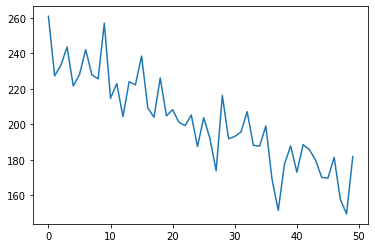

In [13]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [18]:

torch.save(model.state_dict(), 'ckpt/01.pt')

In [22]:
def a(**kwargs):
    print(kwargs)
    print(**kwargs)
a(a='b')

{'a': 'b'}


TypeError: 'a' is an invalid keyword argument for print()